In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install kaggle

In [3]:
import os
os.getcwd()

'/kaggle/working'

In [4]:
os.listdir()

['.virtual_documents']

In [5]:
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [6]:
# !pip install kaggle

In [7]:
# os.chdir('/content/drive/MyDrive/gdrive')

In [8]:
# !kaggle datasets download -d swapnilpanda/heart-sound-database

In [9]:
os.listdir('/kaggle/input/heart-sound-database/heart_sound')

['val', 'train']

In [10]:
# zip_path = '/content/drive/MyDrive/gdrive/heart-sound-database.zip'

In [11]:
# !cp {'zip_path'}

In [12]:
# !unzip -q 'heart-sound-database.zip'

In [13]:
# data = os.path.join('/content/drive/MyDrive/gdrive/heart_sound')

In [14]:
data = os.path.join('/kaggle/input/heart-sound-database/heart_sound')

In [15]:
data

'/kaggle/input/heart-sound-database/heart_sound'

In [16]:
train_dir_path = os.path.join(data, 'train')
valid_dir_path = os.path.join(data, 'val')

In [17]:
train_dir_path

'/kaggle/input/heart-sound-database/heart_sound/train'

In [18]:
valid_dir_path

'/kaggle/input/heart-sound-database/heart_sound/val'

In [19]:
# pip install tensorflow-io

In [20]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [22]:
healthy = os.path.join(train_dir_path, 'healthy', 'a0009.wav')
unhealthy = os.path.join(train_dir_path, 'unhealthy', 'a0001.wav')

In [23]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [24]:
wave = load_wav_16k_mono(healthy)
nwave = load_wav_16k_mono(unhealthy)

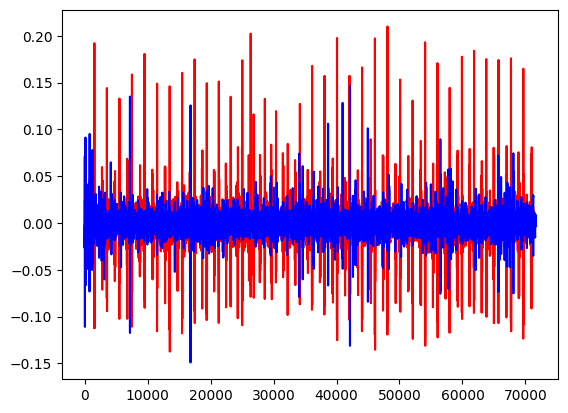

In [25]:
plt.plot(nwave, color='red')
plt.plot(wave, color='blue')
plt.show()

In [26]:
healthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/healthy'+'/*.wav')
unhealthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/unhealthy'+'/*.wav')

In [27]:
healthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/healthy'+'/*.wav')
unhealthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/unhealthy'+'/*.wav')

In [28]:
hhl_train = tf.data.Dataset.zip((healthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_train)))))
uhl_train = tf.data.Dataset.zip((unhealthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_train)))))
train_data = hhl_train.concatenate(uhl_train)

In [29]:
hhl_valid = tf.data.Dataset.zip((healthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_valid)))))
uhl_valid = tf.data.Dataset.zip((unhealthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_valid)))))
valid_data = hhl_valid.concatenate(uhl_valid)

In [30]:
train_data = train_data.concatenate(valid_data)

In [31]:
lengths = []
for f in os.listdir(os.path.join(train_dir_path, 'healthy')):
    tensor_wave = load_wav_16k_mono(os.path.join(train_dir_path, 'healthy', f))
    lengths.append(len(tensor_wave))

In [32]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=43318>

In [33]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=13215>

In [34]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=203346>

In [35]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:40000]
    zero_padding = tf.zeros([40000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=80, frame_step=40)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [36]:
iterator = hhl_train.shuffle(buffer_size=10000).as_numpy_iterator()

In [37]:
iterator.next()

(b'/kaggle/input/heart-sound-database/heart_sound/train/healthy/e00160.wav',
 1.0)

In [38]:
try:
    filepath, label = next(iterator)  # Assuming it returns a tuple with two values
except StopIteration:
    # Handle the case where the iterator is empty
    print("Iterator is empty")

In [39]:
spectrogram, label = preprocess(filepath, label)

In [40]:
spectrogram

<tf.Tensor: shape=(999, 65, 1), dtype=float32, numpy=
array([[[3.5710520e-01],
        [4.2026535e-01],
        [3.8443714e-01],
        ...,
        [6.2452495e-04],
        [1.2611736e-03],
        [2.1659732e-03]],

       [[5.5713451e-01],
        [5.2820945e-01],
        [4.1270944e-01],
        ...,
        [1.9102757e-03],
        [1.8464455e-03],
        [1.6764104e-03]],

       [[3.6704576e-01],
        [3.3338222e-01],
        [2.1522561e-01],
        ...,
        [1.7608671e-03],
        [1.4071227e-03],
        [1.3142377e-03]],

       ...,

       [[1.9734791e-01],
        [2.1966895e-01],
        [2.5286931e-01],
        ...,
        [9.0348546e-04],
        [9.5832732e-04],
        [1.1234507e-03]],

       [[1.5282783e-01],
        [2.0455858e-01],
        [2.6446536e-01],
        ...,
        [5.3699809e-04],
        [7.1842124e-04],
        [8.6195022e-04]],

       [[2.4235535e-01],
        [2.0764603e-01],
        [1.4458682e-01],
        ...,
        [1.9162564e-

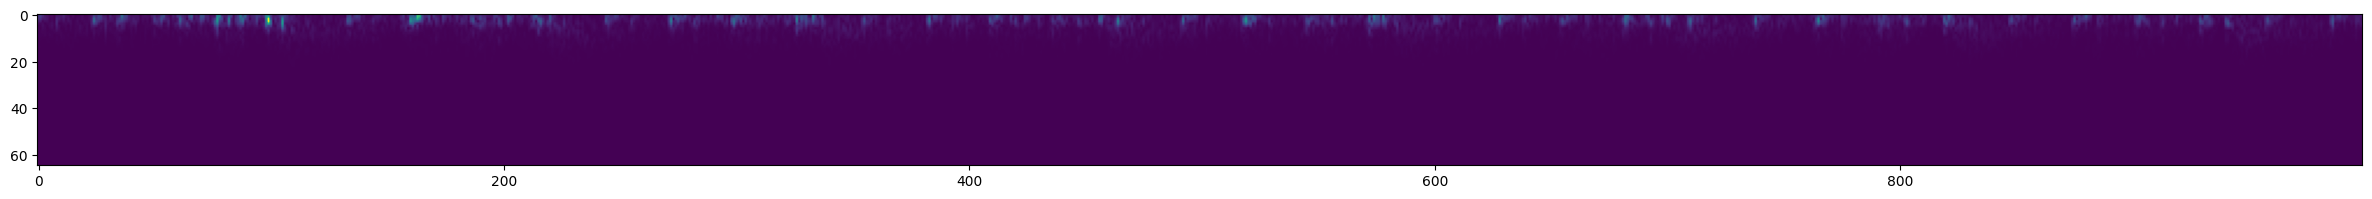

In [41]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()


In [42]:
train_data = train_data.map(preprocess)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(8)
train_data = train_data.prefetch(4)

In [43]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 65, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [44]:
num_samples = tf.data.experimental.cardinality(train_data).numpy()
print(f"Number of samples in train_data: {num_samples}")

Number of samples in train_data: 443


In [45]:
train = train_data.take(400)
test = train_data.skip(400).take(43)

In [46]:
samples, labels = train.as_numpy_iterator().next()

In [47]:
samples.shape

(8, 999, 65, 1)

In [48]:
labels

array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [50]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(999, 65, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [51]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 997, 63, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 995, 61, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 971120)            0         
                                                                 
 dense (Dense)               (None, 128)               124303488 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,306,097
Trainable params: 124,306,097
Non-trainable params: 0
_________________________________________________________________


In [53]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20
400/400 [==============================] - 31s 47ms/step - loss: 1.7694 - recall: 0.9192 - precision: 0.9058 - val_loss: 0.5844 - val_recall: 0.6506 - val_precision: 0.8926
Epoch 2/20
400/400 [==============================] - 16s 41ms/step - loss: 0.2536 - recall: 0.8989 - precision: 0.9431 - val_loss: 0.3783 - val_recall: 0.8253 - val_precision: 0.8204
Epoch 3/20
400/400 [==============================] - 16s 41ms/step - loss: 0.2282 - recall: 0.9028 - precision: 0.9584 - val_loss: 0.3629 - val_recall: 0.6608 - val_precision: 0.9339
Epoch 4/20
400/400 [==============================] - 16s 41ms/step - loss: 0.2092 - recall: 0.8851 - precision: 0.9699 - val_loss: 0.3568 - val_recall: 0.7614 - val_precision: 0.9571
Epoch 5/20
400/400 [==============================] - 16s 41ms/step - loss: 0.1970 - recall: 0.9101 - precision: 0.9765 - val_loss: 0.2691 - val_recall: 0.7337 - val_precision: 0.9783
Epoch 6/20
400/400 [==============================] - 16s 41ms/step - loss: 0.16

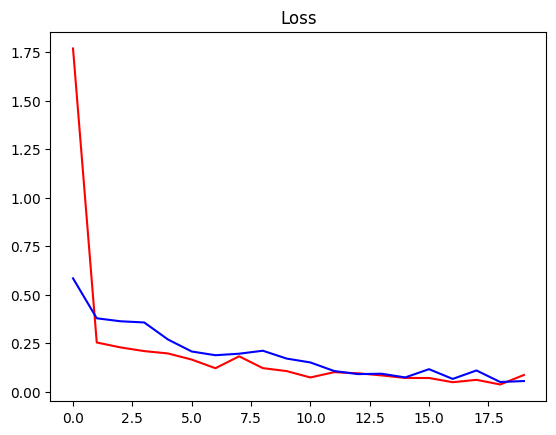

In [54]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

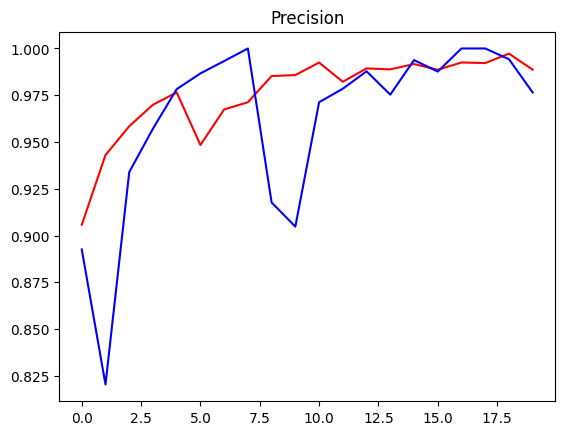

In [56]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

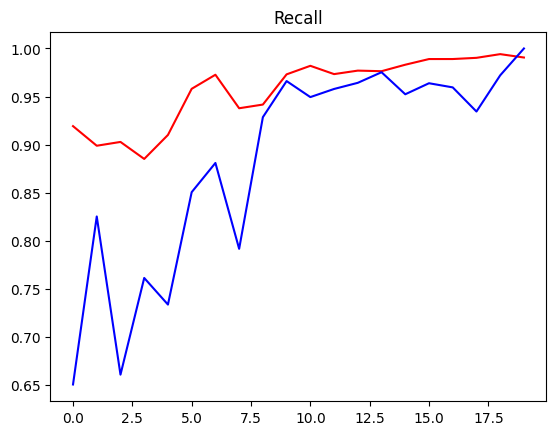

In [58]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [59]:
model.save('heartdisease_predictor_from_audio.h5')

In [60]:
X_test, y_test = test.as_numpy_iterator().next()

In [64]:
X_test.shape

(8, 999, 65, 1)

In [65]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 116ms/step


In [66]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [67]:
print(y_test, yhat)

[1. 1. 0. 0. 1. 0. 1. 1.] [1, 1, 0, 0, 1, 0, 1, 1]
